In [1]:
! nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
! if [ -d HSE.Deep_Unsupervised_Learning ]; then rm -Rf HSE.Deep_Unsupervised_Learning; fi
! git clone https://github.com/SpirinEgor/HSE.Deep_Unsupervised_Learning.git
%cd HSE.Deep_Unsupervised_Learning
! git checkout hw4

Cloning into 'HSE.Deep_Unsupervised_Learning'...
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (371/371), done.
remote: Compressing objects: 100% (243/243), done.
^Cceiving objects:  20% (75/371)
fetch-pack: unexpected disconnect while reading sideband packet
[Errno 2] No such file or directory: 'HSE.Deep_Unsupervised_Learning'
/Users/Egor.Spirin/HSE/HSE.Deep_Unsupervised_Learning/Homework/hw4
M	Homework/hw3/Homework3_autoregressive_flows.ipynb
M	Homework/hw4/Homework4_cnf.ipynb
A	cnf/__init__.py
M	cnf/cnf_impl.py
A	cnf/trainer.py
Already on 'hw4'
Your branch is up to date with 'origin/hw4'.


In [ ]:
! pip install -r requirements.txt

In [ ]:
! git pull

In [3]:
%cd ../..

/Users/Egor.Spirin/HSE/HSE.Deep_Unsupervised_Learning


In [4]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset

from cnf import CNFTrainer, ContiguousNormalizedFlow
from utils.pr3_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
plt.rcParams["axes.labelsize"] = 25.0
plt.rcParams["xtick.labelsize"] = 20.0
plt.rcParams["ytick.labelsize"] = 20.0
plt.rcParams["legend.fontsize"] = 18.0

plt.rcParams["figure.figsize"] = [8.0, 6.0]

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: 2D Data


Dataset 1


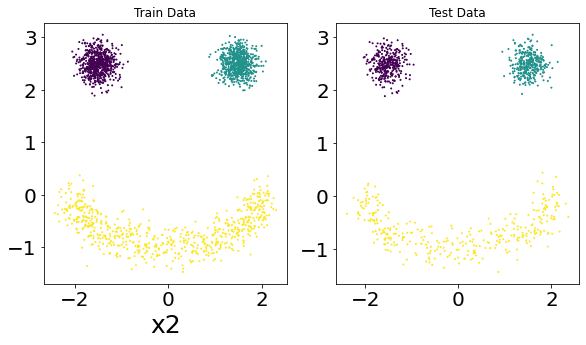

Dataset 2


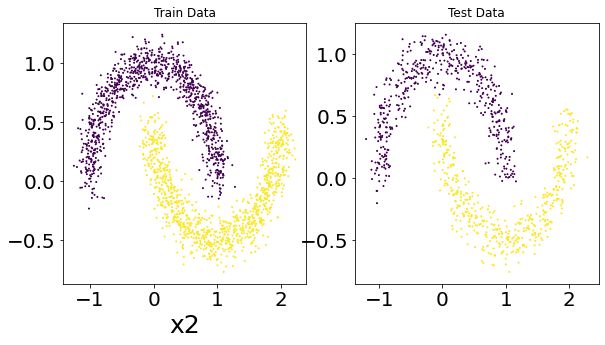

In [7]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Continious Normalazing Flow

Implement continious normalazing flow from [here](https://arxiv.org/pdf/1806.07366.pdf) (botom of page 4). We will be using following transformation parametrization of $\frac{dz(t)}{dt}$:

$\frac{dz(t)}{dt} = u \tanh(\omega^t z(t) + b) \Rightarrow \frac{\partial \log p(z(t))}{\partial z} = - u^t \frac{\partial h}{\partial z}$


Here $\omega, u$ have same dim as $z$ and $b$ is a scalar.

Parametrize $u, \omega, b$ with neural network with single input t. You may find it useful to icrease the 'width' of tansformation by performing m transformation and then averaging them.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model
* Show a heatmap of the densities learned by your model
* Show what the training set looks like when mapped to the latent space.

## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.



In [16]:
class R2Dataset(Dataset):
    def __init__(self, data: torch.Tensor):
        self._data = torch.tensor(data, dtype=torch.float32)
    def __getitem__(self, item: int) -> torch.Tensor:
        return self._data[item]
    def __len__(self) -> int:
        return self._data.shape[0]

def q1(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets, or
               for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity).
        Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents
        mapping the train set data points through our flow to the latent space.
    """
    train_dataloader = DataLoader(R2Dataset(train_data), batch_size=128, shuffle=True)
    test_dataloader = DataLoader(R2Dataset(test_data), batch_size=256)

    zeros = torch.zeros(train_data.shape[1], device=device)
    eye = torch.eye(train_data.shape[1], device=device)
    cnf = ContiguousNormalizedFlow(train_data.shape[1], [32, 32], 3, [zeros, eye])
    cnf = cnf.to(device)

    trainer = CNFTrainer(cnf, device)
    train_losses, test_losses = trainer.fit(
        train_dataloader, n_epochs=10, lr=1e-3, weight_decay=1e-6, clip_norm=5, test_dataloader=test_dataloader
    )

    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    else:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)

    y, x = np.mgrid[
        slice(y_lim[0], y_lim[1] + dy, dy),
        slice(x_lim[0], x_lim[1] + dx, dx)
    ]

    mesh_xs = np.stack([x, y], axis=2).reshape(-1, 2)
    mesh_xs_dataloader = DataLoader(R2Dataset(mesh_xs), batch_size=128, shuffle=False)

    densities = trainer.calc_probabilities(mesh_xs_dataloader).detach().cpu().numpy()

    latents = trainer.extract_latent_vectors(train_dataloader).detach().cpu().numpy()

    return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Final Test Loss: 2.1373


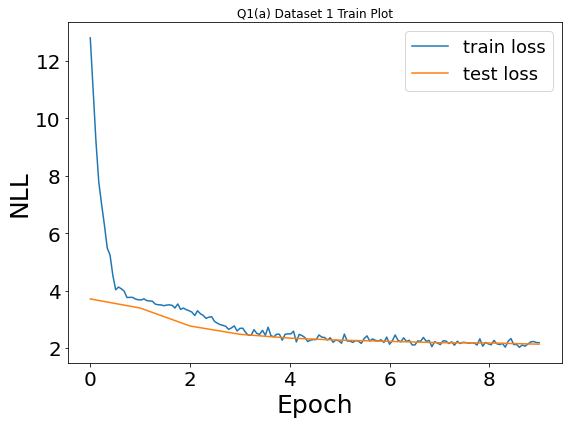

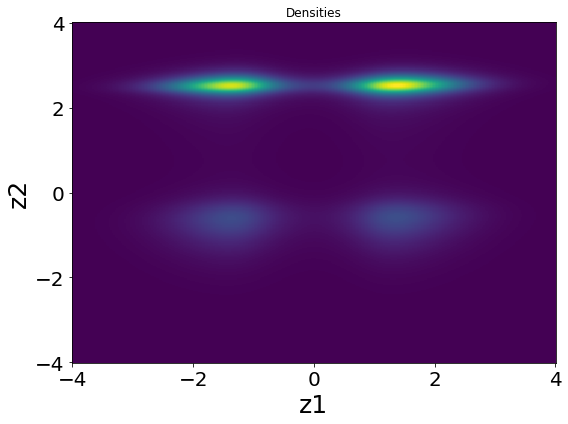

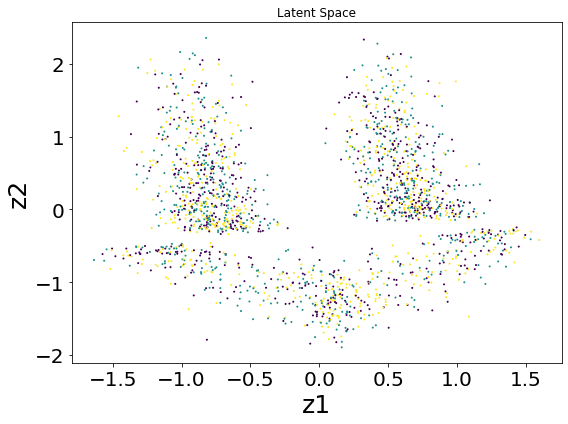

In [17]:
q1_save_results(1, "a", q1)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Calculating probabilities:   0%|          | 0/128 [00:00<?, ?it/s]

Extracting latent vectors:   0%|          | 0/16 [00:00<?, ?it/s]

Final Test Loss: 1.9285


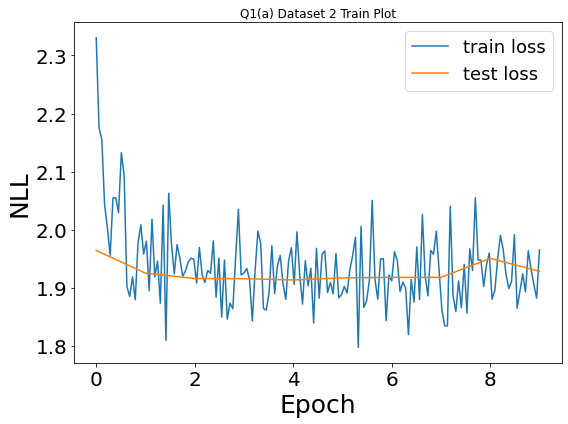

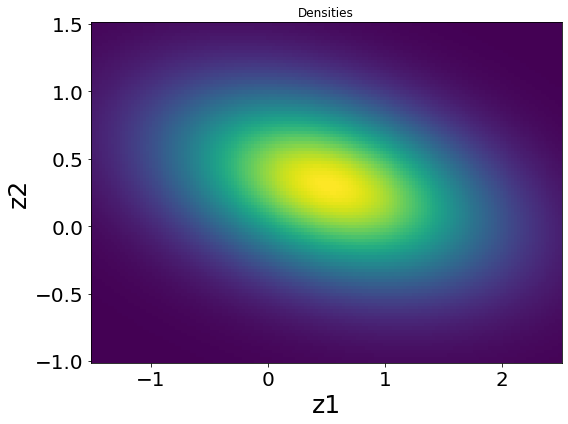

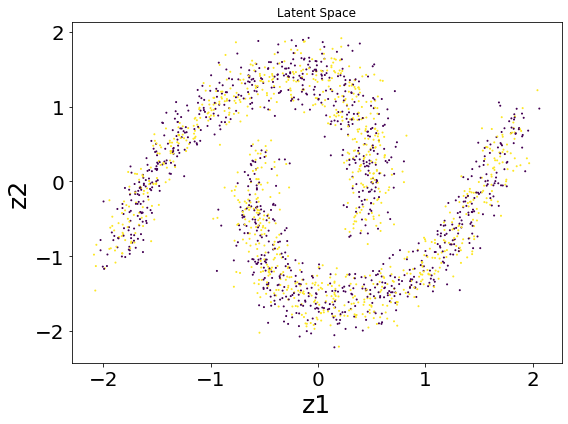

In [18]:
q1_save_results(2, "a", q1)

# Question 2: Hutchinson's trace estimator

Implement CNF with Hutchinson trace estimator.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 10) numpy array of floats in R^10
    test_data: An (n_test, 10) numpy array of floats in R^10
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets, or
               for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    """

    """ YOUR CODE HERE """

### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



In [ ]:
q2_save_results(q2)

# Bonus 3: CNF

Implement CNF with Hutchinson trace estimator and bottleneck trick

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def b3(train_data, test_data):
    """
    train_data: An (n_train, 10) numpy array of floats in R^10
    test_data: An (n_test, 10) numpy array of floats in R^10
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets, or
               for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    """

    """ YOUR CODE HERE """

### Results

Once you've implemented `b3`, execute the cells below to visualize and save your results



In [ ]:
q2_save_results(b3)